# Importing the required packages

In [1]:
import sys
import numpy as np
import ntpath
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

sys.path.append("../src")
from transformations import colour_spaces

In [2]:
def scatter_3D(LAB, RGB, title, save=False, path=''):
    """Plotting the points in a 3D space."""
    matplotlib.rc('xtick', labelsize=18)
    matplotlib.rc('ytick', labelsize=18)
    fontsiz = 20
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.scatter(LAB[:,:,0], LAB[:,:,1], LAB[:,:,2], color = RGB.reshape(-1,3)/255)
    ax.set_xlabel('L*', fontsize = fontsiz)
    ax.set_ylabel('a*', fontsize = fontsiz)
    ax.set_zlabel('b*', fontsize = fontsiz)
    #plt.title(title)
    #plt.show()
    if save:
        fig.savefig(path, dpi = 300)
    else:
        fig.suptitle(ntpath.basename(path)[:-4], fontsize=fontsiz)
#     plt.close()


def scatter_2D(LAB, RGB, title, save=False, path='', fixed_xlim=True, fixed_ylim=True):
    """Plotting three planes of a 3D space."""
    matplotlib.rc('xtick', labelsize=18)
    matplotlib.rc('ytick', labelsize=18)
    fontsiz = 20
    fig = plt.figure(figsize = (9, 3))
    ax1 = fig.add_subplot(131)
    ax1.scatter(LAB[:,0], LAB[:,1], s=15, marker='o', color = RGB/255)
    ax1.set_xlabel('L*', fontsize = fontsiz)
    ax1.set_ylabel('a*', fontsize = fontsiz)
    if fixed_xlim:
        ax1.set_xlim(-10, 110)
    if fixed_ylim:
        ax1.set_ylim(-110,110)
    #ax1.set_yticks([])
    #ax1.set_xticks([])
    ax2 = fig.add_subplot(132)
    ax2.scatter(LAB[:,0], LAB[:,2], s=15, marker='o', color = RGB/255)
    ax2.set_xlabel('L*', fontsize = fontsiz)
    ax2.set_ylabel('b*', fontsize = fontsiz)
    if fixed_xlim:
        ax2.set_xlim(-10, 110)
    if fixed_ylim:
        ax2.set_ylim(-110, 110)
    ax2.set_yticks([])
    #ax2.set_xticks([])
    ax3 = fig.add_subplot(133)
    ax3.scatter(LAB[:,1], LAB[:,2], s=15, marker='o', color = RGB/255)
    ax3.set_xlabel('a*',fontsize = fontsiz)
    ax3.set_ylabel('b*',fontsize = fontsiz)
    if fixed_xlim:
        ax3.set_xlim(-110, 110)
    if fixed_ylim:
        ax3.set_ylim(-110, 110)
    ax3.set_yticks([])
    #ax3.set_xticks([])
    #fig.text(0.5,0.96,title,ha='center',fontsize = 15)  
    #plt.show()
    if save:
        fig.tight_layout()
        fig.savefig(path, dpi = 400)
    else:
        fig.suptitle(ntpath.basename(path)[:-4], fontsize=fontsiz)
#     plt.close()


def Extract_rsqu(addr):
    Rsqu = np.loadtxt(addr, delimiter = ',')
    return Rsqu


def Extract_Matrices_and_eigenvalues(list_addrs):
    MATRICES = [np.loadtxt(addr, delimiter = ',') for addr in list_addrs]

    EIG_VALS = [np.sort(np.linalg.eig(M)[0])[::-1] for M in MATRICES]
    EIG_VECTS = [np.linalg.eig(M)[1] for M in MATRICES] # careful, not sorted
    return MATRICES, EIG_VALS, EIG_VECTS


def Singularity_idx(eigs):
    normeigs = np.array([np.linalg.norm(eig) for eig in eigs])

    Beta1 = 1 - normeigs[1]/normeigs[0]
    Beta2 = 1 - normeigs[2]/normeigs[1]

    return 1 - normeigs[2]/normeigs[0]

# Reading the transformation matrices

In [3]:
transformations_dir = '../lesion/transformation_matrices/k008_d128/'

In [4]:
# list of conversions
conversions = ['rgb', 'lab', 'dkl']

# number of vectors in the embedding space
nb_vect = 8

which_pixels = 'MostChangedPixels'
ADDRS_transfo = {}
RSQU = {}
MATRICES, EIG_VALS, EIG_VECTS = {}, {}, {}
SING = {}
for conv in conversions:
    ADDRS_transfo[conv] = [transformations_dir + '%sL%s%s.txt'%(conv, i+1, which_pixels) for i in range(nb_vect)]
    RSQU[conv] = Extract_rsqu(transformations_dir + '%sRSQ_%s.txt' % (conv, which_pixels))
    MATRICES[conv], EIG_VALS[conv], EIG_VECTS[conv] = Extract_Matrices_and_eigenvalues(ADDRS_transfo[conv])
    SING[conv] = np.array([Singularity_idx(eigs) for eigs in EIG_VALS[conv]])

# Create RGB cube

In [5]:
R = np.tile(np.arange(0, 1, 0.1), (100, 1)).T.reshape(-1, 1)
G = np.tile(np.arange(0, 1, 0.1), (10, 10)).T.reshape(-1, 1)
B = np.tile(np.arange(0, 1, 0.1), (1, 100)).T.reshape(-1, 1)

# regular sample of RGB cube
RGB  = np.stack((R, G, B), axis=2) * 255
# RGB cube in LAB space
LAB = colour_spaces.rgb2opponency((RGB.astype('uint8')).reshape(1,-1,3))

# Plotting the RGB cube in the CIE L*a*b* colour space

## The ogirignal RGB cube

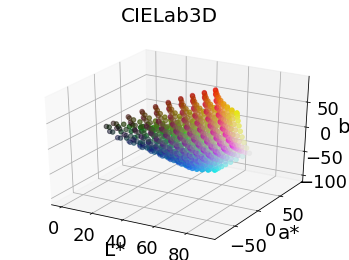

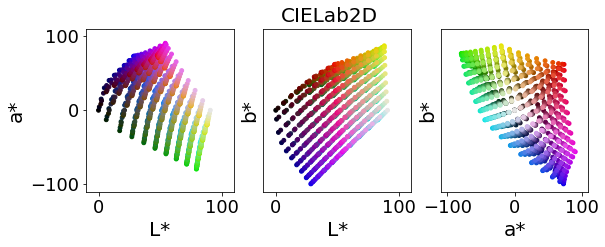

In [6]:
# scatter plot for RGB cube in CIELAB
save = False

# out_folder in case save is True
save_dir = "../figures/"

scatter_3D(LAB, RGB, 'CIELab', save=save, path=save_dir+'/CIELab3D.pdf')
scatter_2D(LAB.reshape(-1,3), RGB.reshape(-1,3), 'CIELab', save=save, path=save_dir+'/CIELab2D.eps')

## The space after applying lesion transformation

### rgb2dkl

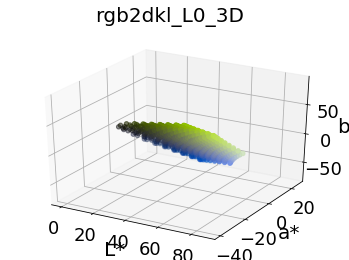

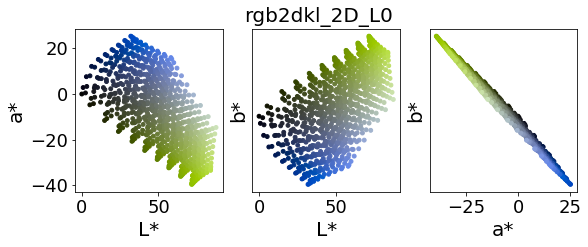

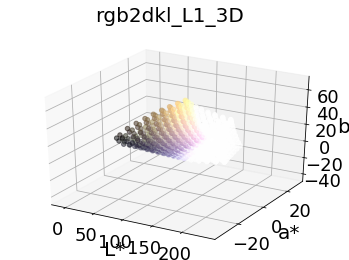

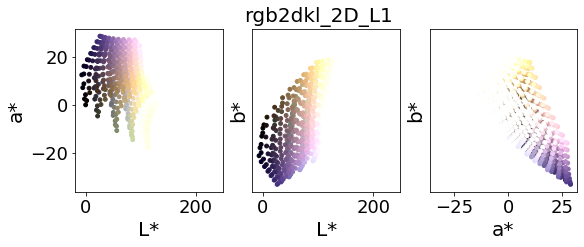

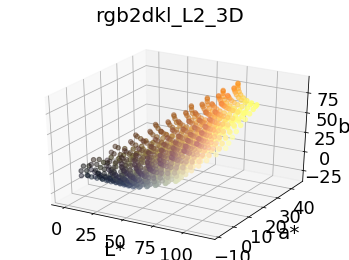

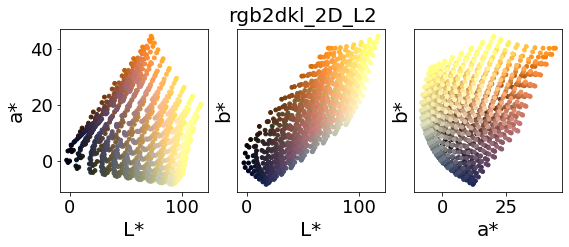

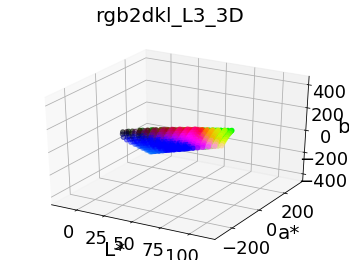

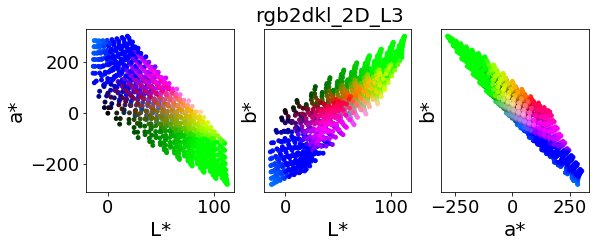

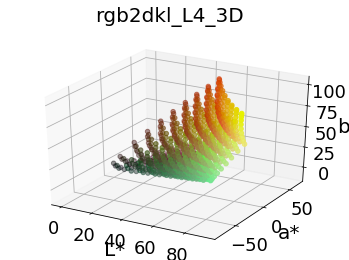

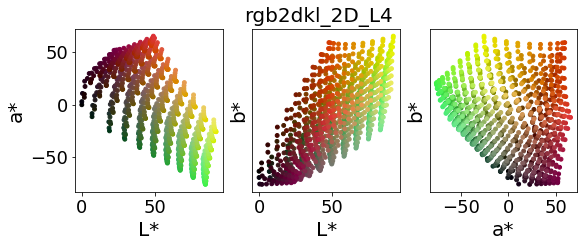

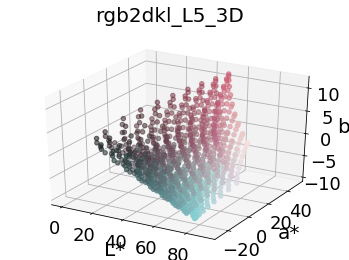

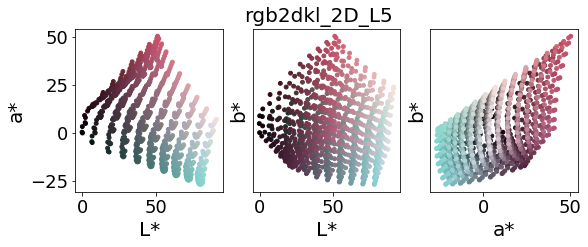

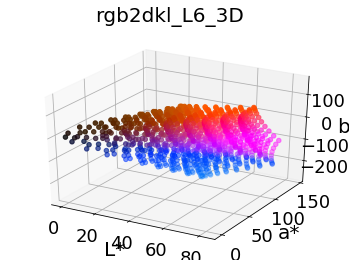

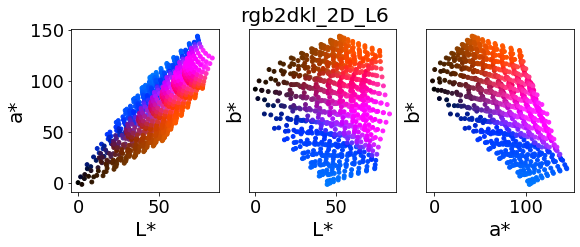

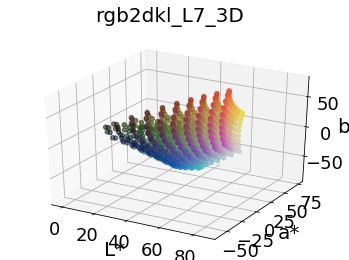

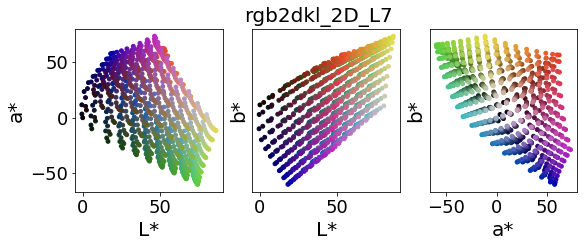

In [7]:
save = False
conv = 'dkl'

# if set to True the range of axes will be forced in the original CIE L*a*b* space.
# there is a large difference between lesion efefcts, so for interpretation it might
# be easier to retain their own range in plotting to appreciate the effect.
fixed_xlim = False
fixed_ylim = False

for i in range(nb_vect):
    s1 = str(np.round(RSQU[conv][i][1],2))
    s2 = str(np.round(SING[conv][i],2))
    trans = np.dot(LAB, MATRICES[conv][i])
    scatter_3D(
        trans, colour_spaces.opponency2rgb(trans.astype('float32')).astype('float'), 
        'R: %s, SI: %s' %(s1, s2),
        save=save, path=save_dir+'/rgb2%s_L%i_3D.pdf'%(conv,i)
    )
    scatter_2D(
        np.dot(LAB, MATRICES[conv][i]).reshape(-1,3), 
        colour_spaces.opponency2rgb(trans.astype('float32')).astype('float').reshape(-1,3), 
        'R: %s, SI: %s' %(s1, s2), save=save, path=save_dir+'/rgb2%s_2D_L%i.eps'%(conv, i),
        fixed_xlim=fixed_xlim, fixed_ylim=fixed_ylim
    )

### rgb2lab 

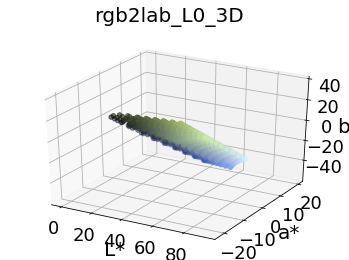

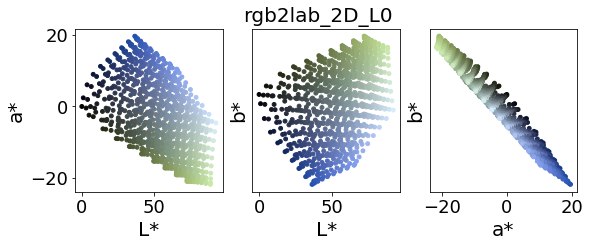

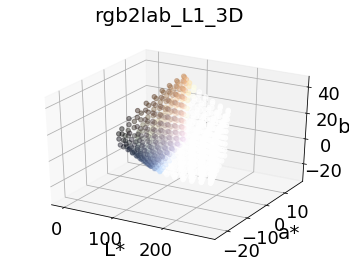

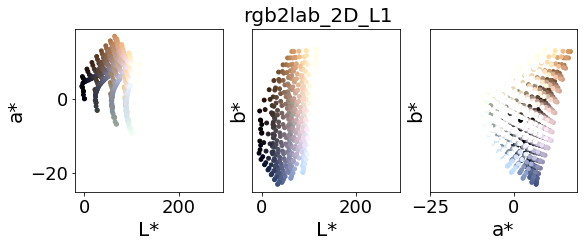

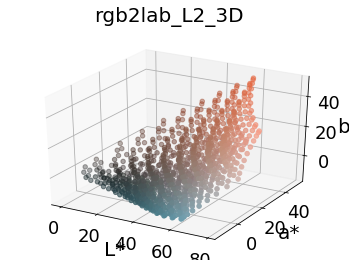

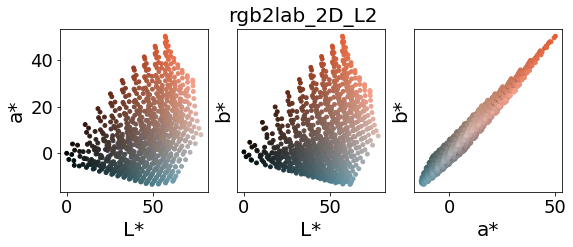

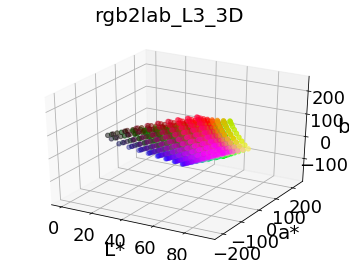

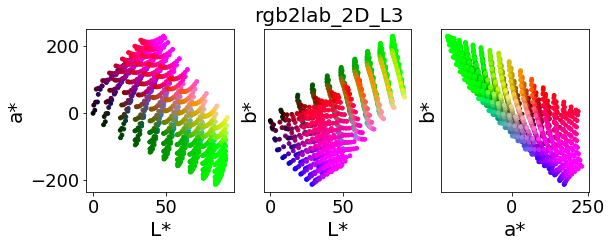

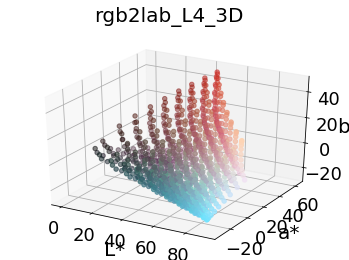

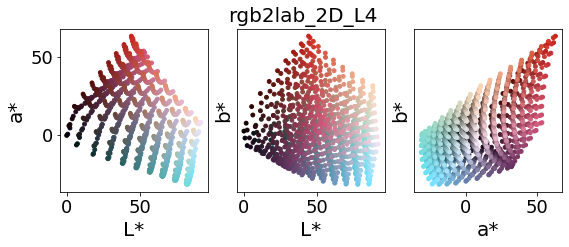

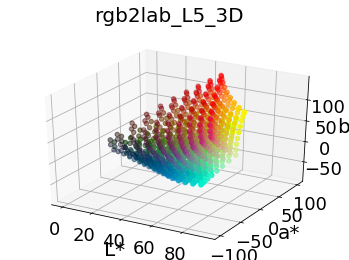

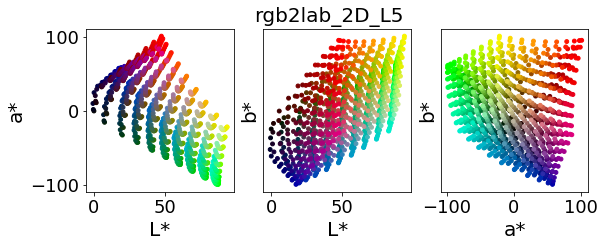

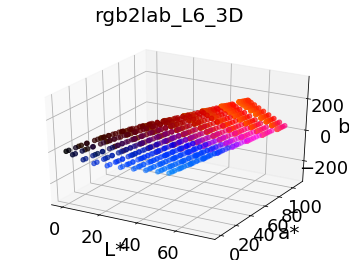

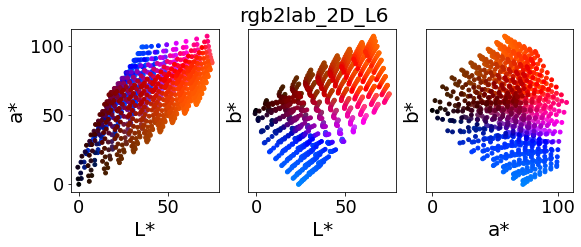

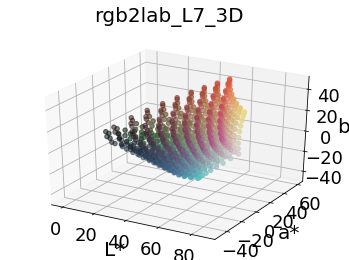

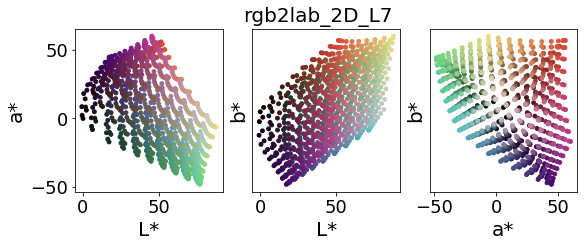

In [8]:
save = False
conv = 'lab'

# if set to True the range of axes will be forced in the original CIE L*a*b* space.
# there is a large difference between lesion efefcts, so for interpretation it might
# be easier to retain their own range in plotting to appreciate the effect.
fixed_xlim = False
fixed_ylim = False

for i in range(nb_vect):
    s1 = str(np.round(RSQU[conv][i][1],2))
    s2 = str(np.round(SING[conv][i],2))
    trans = np.dot(LAB, MATRICES[conv][i])
    scatter_3D(
        trans, colour_spaces.opponency2rgb(trans.astype('float32')).astype('float'), 
        'R: %s, SI: %s' %(s1, s2),
        save=save, path=save_dir+'/rgb2%s_L%i_3D.pdf'%(conv,i)
    )
    scatter_2D(
        np.dot(LAB, MATRICES[conv][i]).reshape(-1,3), 
        colour_spaces.opponency2rgb(trans.astype('float32')).astype('float').reshape(-1,3), 
        'R: %s, SI: %s' %(s1, s2), save=save, path=save_dir+'/rgb2%s_2D_L%i.eps'%(conv, i),
        fixed_xlim=fixed_xlim, fixed_ylim=fixed_ylim
    )

### rgb2rgb

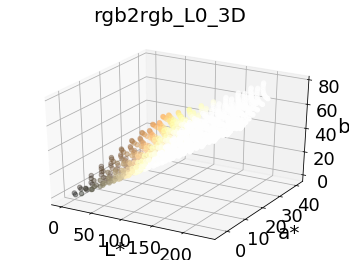

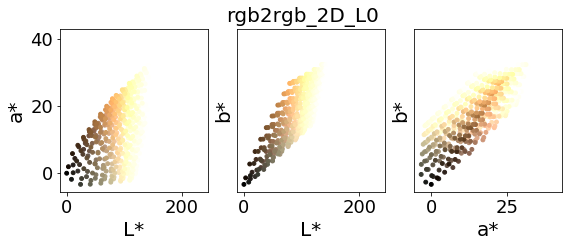

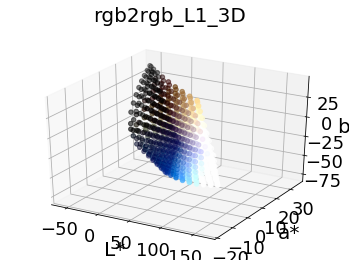

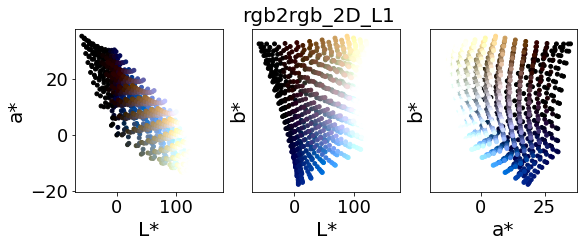

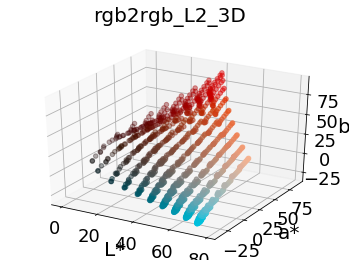

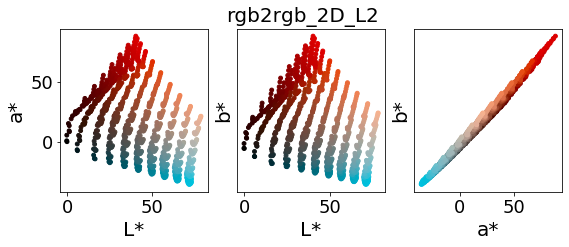

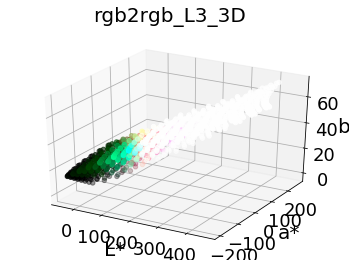

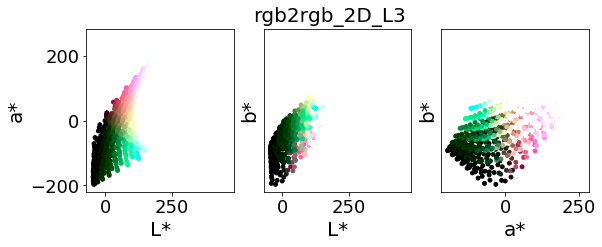

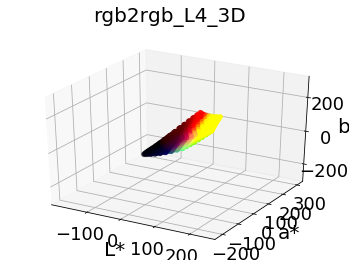

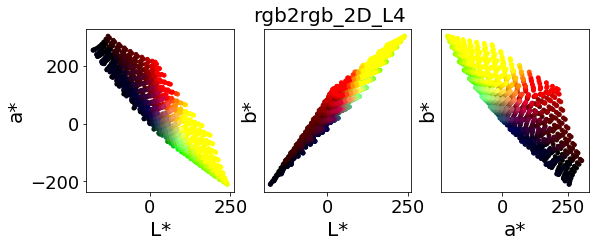

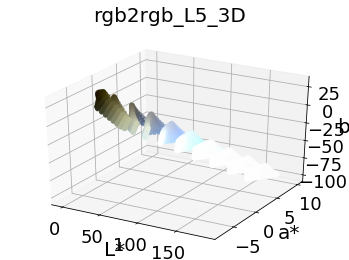

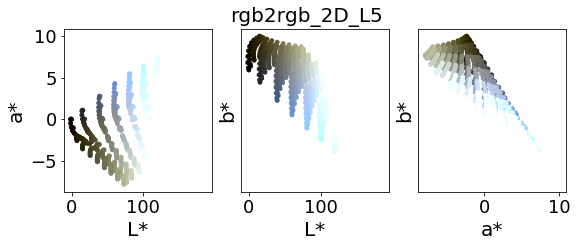

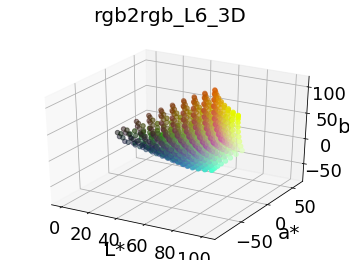

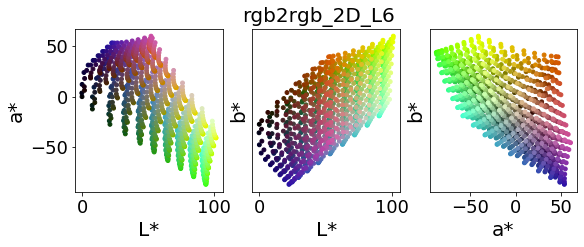

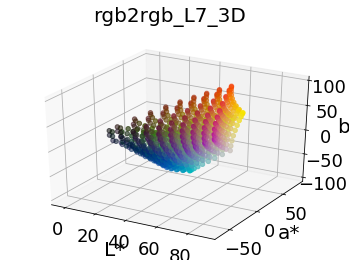

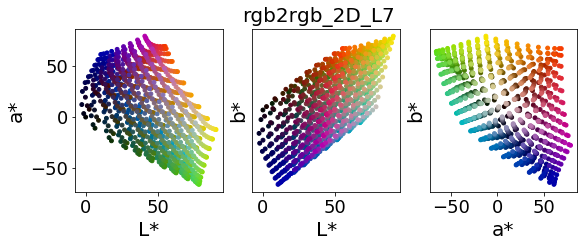

In [9]:
save = False
conv = 'rgb'

# if set to True the range of axes will be forced in the original CIE L*a*b* space.
# there is a large difference between lesion efefcts, so for interpretation it might
# be easier to retain their own range in plotting to appreciate the effect.
fixed_xlim = False
fixed_ylim = False

for i in range(nb_vect):
    s1 = str(np.round(RSQU[conv][i][1],2))
    s2 = str(np.round(SING[conv][i],2))
    trans = np.dot(LAB, MATRICES[conv][i])
    scatter_3D(
        trans, colour_spaces.opponency2rgb(trans.astype('float32')).astype('float'), 
        'R: %s, SI: %s' %(s1, s2),
        save=save, path=save_dir+'/rgb2%s_L%i_3D.pdf'%(conv,i)
    )
    scatter_2D(
        np.dot(LAB, MATRICES[conv][i]).reshape(-1,3), 
        colour_spaces.opponency2rgb(trans.astype('float32')).astype('float').reshape(-1,3), 
        'R: %s, SI: %s' %(s1, s2), save=save, path=save_dir+'/rgb2%s_2D_L%i.eps'%(conv, i),
        fixed_xlim=fixed_xlim, fixed_ylim=fixed_ylim
    )